In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# 数据

## 数据预处理

这个数据集的输出是PILImage，这种图片的输出值范围是[0, 1].我们需要把它们的数值范围变成[-1, 1].

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:06, 24856855.93it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


下面我们显示几张图片。

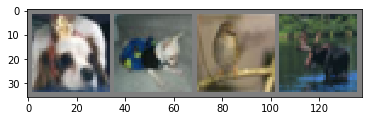

  dog   dog  bird  deer


In [28]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 构建神经网络

## 定义网络模型

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 定义损失函数和优化器

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 训练神经网络

In [9]:
print('Start Training')
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Start Training
[1,  2000] loss: 2.287
[1,  4000] loss: 1.914
[1,  6000] loss: 1.717
[1,  8000] loss: 1.611
[1, 10000] loss: 1.551
[1, 12000] loss: 1.511
[2,  2000] loss: 1.431
[2,  4000] loss: 1.404
[2,  6000] loss: 1.376
[2,  8000] loss: 1.319
[2, 10000] loss: 1.315
[2, 12000] loss: 1.294
Finished Training


## 保存训练好的模型

In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# 验证模型效果

## 随机四张图片

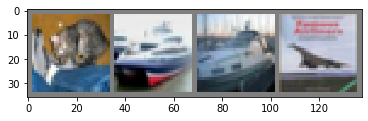

GroundTruth:    cat  ship  ship plane


In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [18]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship plane plane


## 验证数据集

In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 52 %
Accuracy of  bird : 33 %
Accuracy of   cat : 50 %
Accuracy of  deer : 54 %
Accuracy of   dog : 33 %
Accuracy of  frog : 61 %
Accuracy of horse : 63 %
Accuracy of  ship : 55 %
Accuracy of truck : 57 %


# 使用GPU

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


## 将模型放到GPU上

In [23]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## 将数据放到GPU上

In [25]:
print('Start Training')
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Start Training
[1,  2000] loss: 1.254
[1,  4000] loss: 1.259
[1,  6000] loss: 1.264
[1,  8000] loss: 1.268
[1, 10000] loss: 1.254
[1, 12000] loss: 1.265
[2,  2000] loss: 1.259
[2,  4000] loss: 1.262
[2,  6000] loss: 1.250
[2,  8000] loss: 1.260
[2, 10000] loss: 1.262
[2, 12000] loss: 1.274
Finished Training


In [31]:
import cv2
image = cv2.imread("./data/download.png")
cv2.imshow("test", image)